In [1]:
%load_ext autoreload
%autoreload 2
%load_ext functionizer

In [2]:
def save_fig(fig, name):
    fig.savefig(rf"C:\Users\wuyua\OneDrive - The University of Western Ontario\Research\crm\paper\figure\{name}.png", bbox_inches="tight")

In [3]:
from solvers import breakage_grid_1d, BreakageKernel, breakage_pa_1d, log_mean
from compress import compress
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from scipy.integrate import trapz
from scipy.stats import binned_statistic
import pandas as pd

# 1D Breakage on volume grid
## square break kernel

In [4]:
v_edges = np.logspace(-5, 0, 400)
# v_centers = 0.5 * (v_edges[1:] + v_edges[:-1])
v_centers = log_mean(v_edges)
n_init = np.zeros_like(v_centers)
n_init[-1] = 1 / (v_edges[-1] - v_edges[-2])

kernel_coef =1e0
t_total = 10
dt = 0.01

In [5]:
n = n_init.copy()

pbar = tqdm(total=t_total)
t = 0
while t < t_total:
    B, D = breakage_grid_1d(n, v_edges, v_centers, kernel_coef)
    n += (B - D) * dt
    t += dt
    assert np.all(n > 0)
    pbar.update(dt)
pbar.close()

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\wuyua\Projects\PycharmProjects\mvg\solvers.py:637: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for i, Ni in enumerate(N):


In [6]:
N = np.vstack([v_centers, n_init*np.diff(v_edges)]).T
N = N[N[:, -1] > 0]

pbar = tqdm(total=t_total)
t = 0
while t < t_total:
    B, D = breakage_pa_1d(N, kernel_coef, kernel_type=BreakageKernel.SQUARE)
    # assert np.isclose(B[:, -1].sum(), D.sum()*2, rtol=1e-3)
    # assert np.isclose((N[:, 0] * D).sum(), B.prod(axis=1).sum())
    N[:, -1] -= dt * D
    assert np.all(N[:, -1] > 0)
    B[:, -1] *= dt
    N = np.vstack((N, B))
    N = compress(N, 0.1, np.array([1]), 1, log=True)
    t += dt
    pbar.update(dt)

pbar.close()

  0%|          | 0/10 [00:00<?, ?it/s]

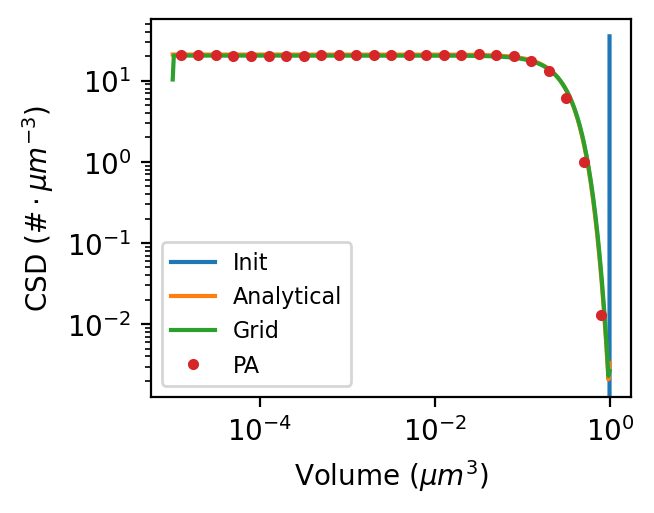

In [7]:
# analytical solution
delta = n_init
n_analytical = np.exp(-v_centers**2*t_total) * (delta + (2 * t_total + v_centers[-1] * (v_centers[-1]-v_centers)))

fig, ax = plt.subplots(dpi=200, figsize=(3.1, 2.5))
ax.plot(v_centers, n_init, label="Init")
ax.plot(v_centers, n_analytical, label="Analytical")
ax.plot(v_centers, n, label="Grid")

g = np.logspace(-5, 0, 26)
stats, xe, bn = binned_statistic(N[:, 0], N[:, 1], statistic="sum", bins=g)
xc = log_mean(xe)
nd = stats / (xe[1:] - xe[:-1])
ax.plot(xc, nd, ".", markevery=1, label="PA")

ax.set_xlabel("Volume $(\mu m^3)$")
ax.set_ylabel("CSD $(\#\cdot \mu m^{-3})$")
ax.legend(fontsize=8)
ax.set_yscale("log")
ax.set_xscale("log")

save_fig(fig, "breakage_square_kernel")

## Linear break kernel

In [8]:
v_edges = np.logspace(-5, 0, 400)
v_centers = log_mean(v_edges)

n_init = np.zeros_like(v_centers)
n_init[-1] = 1 / (v_edges[-1] - v_edges[-2])

kernel_coef =1e0
t_total = 10
dt = 0.01

In [9]:
n = n_init.copy()

pbar = tqdm(total=t_total)
t = 0
while t < t_total:
    B, D = breakage_grid_1d(n, v_edges, v_centers, kernel_coef, kernel_type=BreakageKernel.LINEAR)
    n += (B - D) * dt
    t += dt
    assert np.all(n > 0)
    pbar.update(dt)
pbar.close()

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\wuyua\Projects\PycharmProjects\mvg\solvers.py:637: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for i, Ni in enumerate(N):


In [10]:
N = np.vstack([v_centers, n_init*np.diff(v_edges)]).T
N = N[N[:, -1] > 0]

pbar = tqdm(total=t_total)
t = 0
while t < t_total:
    B, D = breakage_pa_1d(N, kernel_coef, kernel_type=BreakageKernel.LINEAR)
    # assert np.isclose(B[:, -1].sum(), D.sum()*2, rtol=1e-3)
    # assert np.isclose((N[:, 0] * D).sum(), B.prod(axis=1).sum())
    N[:, -1] -= dt * D
    assert np.all(N[:, -1] > 0)
    B[:, -1] *= dt
    N = np.vstack((N, B))
    N = compress(N, 0.1, np.array([1]), 1, log=True)
    t += dt
    pbar.update(dt)

pbar.close()

  0%|          | 0/10 [00:00<?, ?it/s]

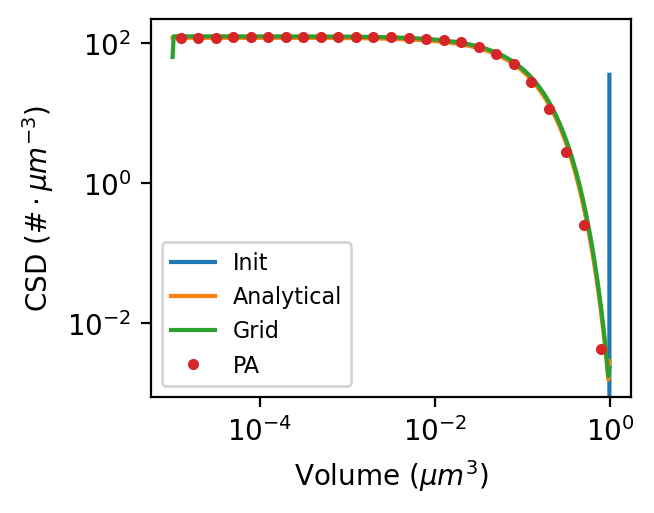

In [11]:
# analytical solution
n_analytical = np.exp(-v_centers[-1]*t_total) * n_init + (2 * t_total + t_total ** 2 * (v_centers[-1]-v_centers)) * np.exp(-v_centers * t_total)

fig, ax = plt.subplots(dpi=200, figsize=(3.1, 2.5))
ax.plot(v_centers, n_init, label="Init")
ax.plot(v_centers, n_analytical, label="Analytical")
ax.plot(v_centers, n, label="Grid")


g = np.logspace(-5, 0, 26)
stats, xe, bn = binned_statistic(N[:, 0], N[:, 1], statistic="sum", bins=g)
xc = log_mean(xe)
nd = stats / (xe[1:] - xe[:-1])
ax.plot(xc, nd, ".", markevery=1, label="PA")

ax.set_xlabel("Volume $(\mu m^3)$")
ax.set_ylabel("CSD $(\#\cdot \mu m^{-3})$")
ax.legend(fontsize=8)
ax.set_yscale("log")
ax.set_xscale("log")

save_fig(fig, "breakage_linear_kernel")

